<a href="https://colab.research.google.com/github/rodmart21/Sports_analytics/blob/main/football_tracking_v5_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Football Players Tracking on a pitch using YOLOv5 + ByteTrack**
## About
In my project, I utilized Roboflow Universe, an open-source computer vision dataset repository with over 100,000 datasets. This platform offered various tools to convert and preprocess data efficiently.

#### Useful links:

* [YOLOv5 repository](https://github.com/ultralytics/yolov5)
* [ByteTrack repository](https://github.com/ifzhang/ByteTrack)
* [Roboflow Notebooks](https://github.com/roboflow/notebooks)


#### Steps Involved:

* Setup<br>
* Download data<br>
* Install YOLOv5<br>
* Install ByteTrack and other libs<br>
* Custom annotator<br>
* Detect ball possession<br>
* Full video tracking<br>
* Put everything together<br>

#### Setup:

In [1]:
!nvidia-smi

Thu May 16 14:38:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [41]:
import os
HOME = os.getcwd()
print(HOME)

/content/yolov5


####Download Data:

In [42]:
!pip install kaggle --upgrade --quiet

I will be using [DFL - Bundesliga Data Shootout](https://www.kaggle.com/competitions/dfl-bundesliga-data-shootout/data) from Kaggle. I will download it using Kaggle API. According to documentation, I need to set up two environment variables first:

    export KAGGLE_USERNAME=datadinosaur


    export KAGGLE_KEY=xxxxxxxxxxxxxx

In [43]:
import os
from getpass import getpass

In [46]:
os.environ['KAGGLE_USERNAME'] = getpass('Enter KAGGLE_USERNAME secret value: ')
os.environ['KAGGLE_KEY'] = getpass('Enter KAGGLE_KEY secret value: ')

Enter KAGGLE_USERNAME secret value: ··········
Enter KAGGLE_KEY secret value: ··········


In [48]:
!pip install kaggle

import os
os.environ['KAGGLE_USERNAME'] = "tu_nombre_de_usuario_en_Kaggle"
os.environ['KAGGLE_KEY'] = "tu_API_key_de_Kaggle"

!kaggle competitions download -c dfl-bundesliga-data-shootout


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 54, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1002, in competition_download_cli
    self.competition_download_files(competition, path, force,
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 965, in competition_download_files
    url = response.retries.history[0].redirect_location.split('?')[0]
IndexError: tuple index out of range


In [47]:
!kaggle competitions files -c dfl-bundesliga-data-shootout | grep clips | head -10

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 54, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 900, in competition_list_files_cli
    files = self.competition_list_files(competition)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 875, in competition_list_files
    return [File(f) for f in competition_list_files_result]
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 875, in <listcomp>
    return [File(f) for f in competition_list_files_result]
  File "/usr/local/lib/python3.10/dist-packages/kaggle/models/kaggle_models_extended.py", line 118, in __init__
    parsed_dict = {k: parse(v) for k, v in init_dict.items()}
AttributeError: 'str' object has no attribute 'items'


In [8]:
%cd {HOME}
!kaggle competitions files -c dfl-bundesliga-data-shootout | \
grep clips | head -20 | \
awk '{print $1}' | \
while read -r line; \
  do kaggle competitions download -c dfl-bundesliga-data-shootout -f $line -p clips --quiet;\
  unzip ${line}.zip -d clips && rm ${line}.zip; \
  done

/content
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 54, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 900, in competition_list_files_cli
    files = self.competition_list_files(competition)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 873, in competition_list_files
    competition_list_files_result = self.process_response(
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 3613, in process_response
    raise Exception(data['message'])
Exception: Unauthorized access


#### Install YOLOv5:

In [9]:
%cd {HOME}
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt

import torch
import utils
display = utils.notebook_init()


YOLOv5 🚀 v7.0-312-g1bcd17ee Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.9/78.2 GB disk)


#### Use pre-trained COCO model

In [10]:
%cd {HOME}/yolov5
!python detect.py --weights yolov5x.pt --img 640 --conf 0.25 --source {HOME}/clips/08fd33_4.mp4 --name coco


/content/yolov5
detect: weights=['yolov5x.pt'], source=/content/clips/08fd33_4.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=coco, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-312-g1bcd17ee Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

100% 166M/166M [00:00<00:00, 201MB/s]

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.5 GFLOPs
Traceback (most recent call last):
  File "/content/yolov5/detect.py", line 312, in <module>
    main(opt)
  File "/content/yolov5/detect.py", line 307, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 115, in decorate_

In [ ]:
# %cd {HOME}/yolov5
# !python detect.py --weights yolov5x6.pt --img 1280 --conf 0.25 --source {HOME}/clips/08fd33_4.mp4 --name coco

#### Use custom model
This model was trained using [football-players-detection](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc) dataset.

In [11]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I" -O best.pt && rm -rf /tmp/cookies.txt

/content
--2024-05-16 15:12:22--  https://docs.google.com/uc?export=download&confirm=&id=1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I
Resolving docs.google.com (docs.google.com)... 74.125.135.101, 74.125.135.138, 74.125.135.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.135.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I&export=download [following]
--2024-05-16 15:12:22--  https://drive.usercontent.google.com/download?id=1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.195.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2419 (2.4K) [text/html]
Saving to: ‘best.pt’

best.pt             100%[===================>]   2.36K  --.-KB/s    in 0s   

In [12]:
WEIGHTS_PATH = f"{HOME}/best.pt"

In [29]:
%cd {HOME}/yolov5
!python detect.py --weights {HOME}/best.pt --img 1280 --conf 0.25 --source {HOME}/clips/08fd33_1.mp4 --name custom

/content/yolov5
detect: weights=['/content/best.pt'], source=/content/clips/08fd33_1.mp4, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=custom, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-312-g1bcd17ee Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Traceback (most recent call last):
  File "/content/yolov5/detect.py", line 312, in <module>
    main(opt)
  File "/content/yolov5/detect.py", line 307, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "/content/yolov5/detect.py", line 115, in run
    model = DetectMultiBacken

#### Use custom model - single frame

In [14]:
from typing import Generator

import matplotlib.pyplot as plt
import numpy as np

import cv2

%matplotlib inline


def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]:
    video = cv2.VideoCapture(video_file)

    while video.isOpened():
        success, frame = video.read()

        if not success:
            break

        yield frame

    video.release()


def plot_image(image: np.ndarray, size: int = 12) -> None:
    plt.figure(figsize=(size, size))
    plt.imshow(image[...,::-1])
    plt.show()


In [30]:
SOURCE_VIDEO_PATH = f"/content/08fd33_1.mp4"

In [32]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

In [49]:
frame_iterator

<generator object generate_frames at 0x7fc41ade3ed0>

In [33]:
frame = next(frame_iterator)
plot_image(frame, 16)

## Carga del modelo

In [35]:
pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

In [ ]:
/content/yolov5
/content/yolov5/models/yolov5s.yaml

In [ ]:
import cv2
image=cv2.imread('')

In [50]:
import torch

# Model
model = torch.hub.load('/content/yolov5/models/hub/yolov5s6.yaml')

# Image
im = 'https://ultralytics.com/images/zidane.jpg'

# Inference
results = model(im)

results.pandas().xyxy[0]

TypeError: load() missing 1 required positional argument: 'model'

In [51]:
WEIGHTS_PATH

'/content/best.pt'

In [34]:
import torch
model = torch.hub.load('ultralytics/yolov5', 'custom', WEIGHTS_PATH, device=0)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-312-g1bcd17ee Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



Exception: invalid load key, '<'.. Cache may be out of date, try `force_reload=True` or see https://docs.ultralytics.com/yolov5/tutorials/pytorch_hub_model_loading for help.

In [26]:
results = model(frame, size=1280)

NameError: name 'model' is not defined

In [ ]:
results.pandas()

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 1080x1920 1 ball, 1 goalkeeper, 19 players, 3 referees
Speed: 8.8ms pre-process, 158.2ms inference, 4.1ms NMS per image at shape (1, 3, 768, 1280)

In [ ]:
results.pred[0]

tensor([[5.33234e+02, 6.87570e+02, 5.78573e+02, 7.84712e+02, 9.73769e-01, 2.00000e+00],
        [3.27560e+02, 4.94221e+02, 3.67715e+02, 5.70054e+02, 9.72061e-01, 2.00000e+00],
        [1.36868e+03, 8.16015e+02, 1.44455e+03, 9.04930e+02, 9.71974e-01, 2.00000e+00],
        [1.30964e+03, 4.47144e+02, 1.35070e+03, 5.16344e+02, 9.67860e-01, 2.00000e+00],
        [1.85383e+03, 8.07013e+02, 1.89357e+03, 9.18096e+02, 9.66307e-01, 3.00000e+00],
        [8.47532e+02, 6.34075e+02, 9.00840e+02, 7.21330e+02, 9.66143e-01, 2.00000e+00],
        [2.21989e+02, 5.13461e+02, 2.55608e+02, 5.94411e+02, 9.64198e-01, 2.00000e+00],
        [1.12392e+03, 7.07760e+02, 1.18086e+03, 7.92754e+02, 9.63277e-01, 2.00000e+00],
        [9.96095e+02, 4.54108e+02, 1.02639e+03, 5.26345e+02, 9.62843e-01, 2.00000e+00],
        [1.57265e+03, 6.11327e+02, 1.61230e+03, 6.94755e+02, 9.62607e-01, 2.00000e+00],
        [1.22946e+03, 4.31551e+02, 1.26351e+03, 5.01717e+02, 9.62112e-01, 2.00000e+00],
        [8.73488e+02, 3.61339e+0

In [ ]:
model.names

{0: 'ball', 1: 'goalkeeper', 2: 'player', 3: 'referee'}

#### Install ByteTrack and other libraries
ByteTrack is great tracker but a bit poorly packaged. We need to jump through some fire hoops to make it work in tandem with YOLOv5.

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
!cd ByteTrack && pip3 install -r requirements.txt
!cd ByteTrack && python3 setup.py develop
!pip install cython_bbox


/content
fatal: destination path 'ByteTrack' already exists and is not an empty directory.
  Using cached ninja-1.11.1-py2.py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (145 kB)
  Using cached motmetrics-1.4.0-py3-none-any.whl (161 kB)
  Using cached filterpy-1.4.5.zip (177 kB)
  Preparing metadata (setup.py) ... done
  Using cached onnx-1.8.1.tar.gz (5.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement onnxruntime==1.8.0 (from versions: 1.12.0, 1.12.1, 1.13.1, 1.14.0, 1.14.1, 1.15.0, 1.15.1)
ERROR: No matching distribution found for onnxruntime==1.8.0
running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ******************************************************************

In [ ]:
import sys
sys.path.append(f"{HOME}/ByteTrack")

In [ ]:
!pip install onemetric --quiet

In [ ]:
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False


In [ ]:
!pip install loguru
!pip install lap

In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch

#### Custom annotator

In [ ]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Tuple, Optional, List, Dict, Any

import cv2

import numpy as np


# geometry utilities


@dataclass(frozen=True)
class Point:
    x: float
    y: float

    @property
    def int_xy_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)
@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float

    @property
    def min_x(self) -> float:
        return self.x

    @property
    def min_y(self) -> float:
        return self.y

    @property
    def max_x(self) -> float:
        return self.x + self.width

    @property
    def max_y(self) -> float:
        return self.y + self.height

    @property
    def top_left(self) -> Point:
        return Point(x=self.x, y=self.y)

    @property
    def bottom_right(self) -> Point:
        return Point(x=self.x + self.width, y=self.y + self.height)

    @property
    def bottom_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height)

    @property
    def top_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y)

    @property
    def center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height / 2)

    def pad(self, padding: float) -> Rect:
        return Rect(
            x=self.x - padding,
            y=self.y - padding,
            width=self.width + 2*padding,
            height=self.height + 2*padding
        )

    def contains_point(self, point: Point) -> bool:
        return self.min_x < point.x < self.max_x and self.min_y < point.y < self.max_y


# detection utilities


@dataclass
class Detection:
    rect: Rect
    class_id: int
    class_name: str
    confidence: float
    tracker_id: Optional[int] = None

    @classmethod
    def from_results(cls, pred: np.ndarray, names: Dict[int, str]) -> List[Detection]:
        result = []
        for x_min, y_min, x_max, y_max, confidence, class_id in pred:
            class_id=int(class_id)
            result.append(Detection(
                rect=Rect(
                    x=float(x_min),
                    y=float(y_min),
                    width=float(x_max - x_min),
                    height=float(y_max - y_min)
                ),
                class_id=class_id,
                class_name=names[class_id],
                confidence=float(confidence)
            ))
        return result

def filter_detections_by_class(detections: List[Detection], class_name: str) -> List[Detection]:
    return [
        detection
        for detection
        in detections
        if detection.class_name == class_name
    ]


# draw utilities


@dataclass(frozen=True)
class Color:
    r: int
    g: int
    b: int

    @property
    def bgr_tuple(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r

    @classmethod
    def from_hex_string(cls, hex_string: str) -> Color:
        r, g, b = tuple(int(hex_string[1 + i:1 + i + 2], 16) for i in (0, 2, 4))
        return Color(r=r, g=g, b=b)


def draw_rect(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, thickness)
    return image


def draw_filled_rect(image: np.ndarray, rect: Rect, color: Color) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, -1)
    return image
def draw_polygon(image: np.ndarray, countour: np.ndarray, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, thickness)
    return image


def draw_filled_polygon(image: np.ndarray, countour: np.ndarray, color: Color) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, -1)
    return image


def draw_text(image: np.ndarray, anchor: Point, text: str, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.putText(image, text, anchor.int_xy_tuple, cv2.FONT_HERSHEY_SIMPLEX, 0.7, color.bgr_tuple, thickness, 2, False)
    return image


def draw_ellipse(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.ellipse(
        image,
        center=rect.bottom_center.int_xy_tuple,
        axes=(int(rect.width), int(0.35 * rect.width)),
        angle=0.0,
        startAngle=-45,
        endAngle=235,
        color=color.bgr_tuple,
        thickness=thickness,
        lineType=cv2.LINE_4
    )
    return image


# base annotator
@dataclass
class BaseAnnotator:
    colors: List[Color]
    thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            annotated_image = draw_ellipse(
                image=image,
                rect=detection.rect,
                color=self.colors[detection.class_id],
                thickness=self.thickness
            )
        return annotated_image


In [ ]:
# white
BALL_COLOR_HEX = "#FFFFFF"
BALL_COLOR = Color.from_hex_string(BALL_COLOR_HEX)

# red
GOALKEEPER_COLOR_HEX = "#850101"
GOALKEEPER_COLOR = Color.from_hex_string(GOALKEEPER_COLOR_HEX)

# green
PLAYER_COLOR_HEX = "#00D4BB"
PLAYER_COLOR = Color.from_hex_string(PLAYER_COLOR_HEX)

# yellow
REFEREE_COLOR_HEX = "#FFFF00"
REFEREE_COLOR = Color.from_hex_string(REFEREE_COLOR_HEX)

COLORS = [
    BALL_COLOR,
    GOALKEEPER_COLOR,
    PLAYER_COLOR,
    REFEREE_COLOR
]
THICKNESS = 4

In [ ]:
# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

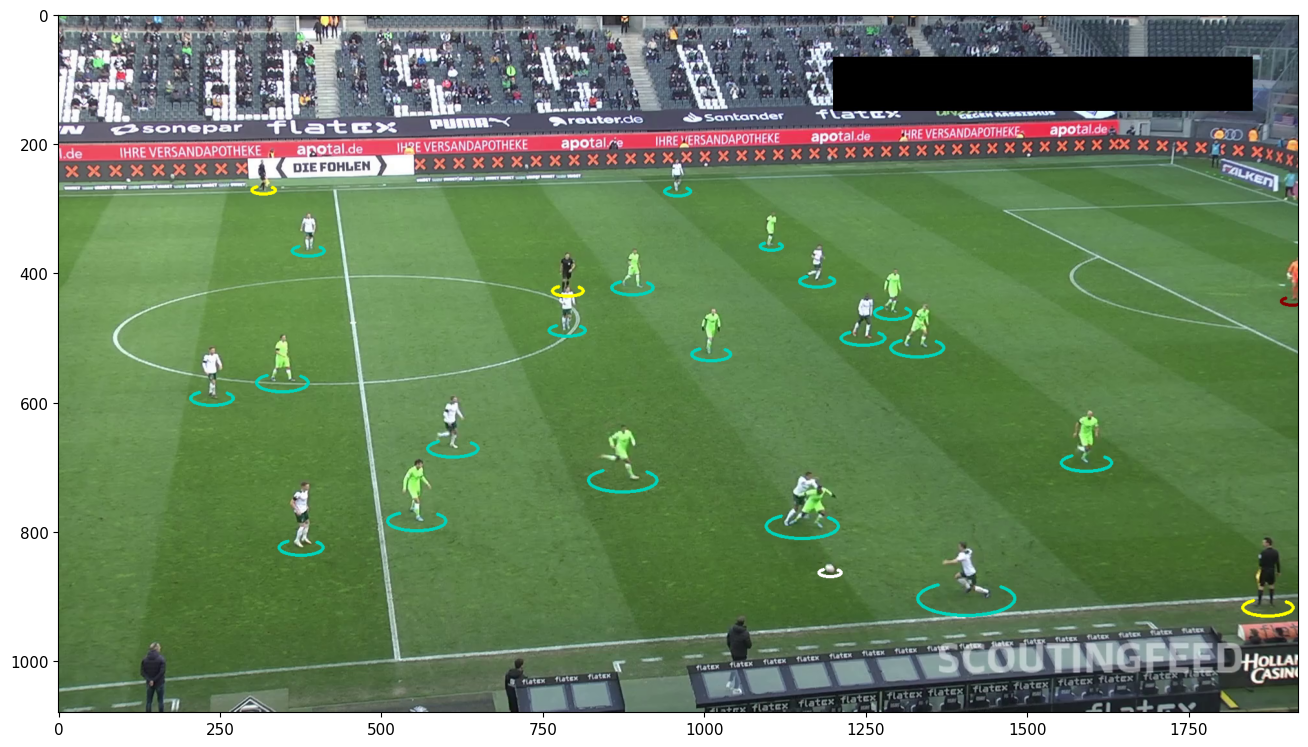

In [ ]:
# initiate annotators
annotator = BaseAnnotator(
    colors=COLORS,
    thickness=THICKNESS)

# acquire video frame
frame = next(frame_iterator)

# run detector
results = model(frame, size=1280)
detections = Detection.from_results(
    pred=results.pred[0].cpu().numpy(),
    names=model.names)

# annotate video frame
annotated_image = annotator.annotate(
    image=frame,
    detections=detections)

# plot video frame
plot_image(annotated_image, 16)
